# pixelSNAIL Training

## Imports

In [1]:
import numpy as np
import os, sys
from functools import partial
import tensorflow as tf


N_WORKERS = 8
    
from tensorflow_addons.layers import WeightNormalization
from tensorflow.keras.layers import Layer, ZeroPadding2D, Conv2D, Dropout, Dense, Input, Concatenate, Reshape, \
    Cropping2D, Activation

   
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from pixelsnail_keras.layers import CausalConv2D, Shift, GatedResidualBlock, NetworkInNetwork, CausalAttentionBlock, SimpleCausalAttentionBlock
from pixelsnail_keras.layers import pixelSNAIL
from pixelsnail_keras.losses import discretized_mix_logistic_loss, sample_from_discretized_mix_logistic
import pixelsnail_keras.loaders as loaders
from pixelsnail_keras.sampling import SampleCallback, sample_from_model

rng = np.random.RandomState(10)
tf.compat.v1.set_random_seed(10)
tf.random.set_seed(10)

## Load Data

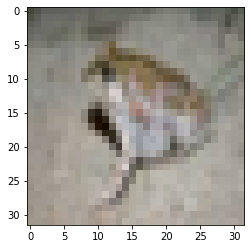

In [2]:
def preprocess(x):
    return (x-127.5)/127.5
    
datagen_train, datagen_test =  loaders.load_cifar_data(preprocess, batch_size=32) #loaders.load_gemstone_data(preprocess, batch_size=32) #

plt.imshow((datagen_train.__next__()[0][0]*127.5 +127.5).astype(int))

In [3]:
def pixelSNAIL(attention=True, out_channels=None, num_pixel_blocks=1, num_grb_per_pixel_block=1, dropout=0.0,
               nr_filters=128):
    nr_logistic_mix = 10
    kernel_size = 3

    x_in = Input(shape=(32, 32, 3))

    k_d = [kernel_size - 1, kernel_size]
    k_dr = [kernel_size - 1, kernel_size - 1]

    u = Shift("down")(CausalConv2D(nr_filters, [kernel_size - 1, kernel_size], shift="down")(x_in))
    ul = Shift("down")(CausalConv2D(nr_filters, [1, kernel_size], shift="down")(x_in))
    ul += Shift("right")(CausalConv2D(nr_filters, [kernel_size - 1, 1], shift="downright")(x_in))

    for i in range(num_pixel_blocks):
        for j in range(num_grb_per_pixel_block):
            u = GatedResidualBlock(x=u, aux=None,
                                   nonlinearity="elu",
                                   dropout=dropout,
                                   conv1=CausalConv2D(filters=nr_filters, kernel_size=k_d, shift="down",
                                                      activation="elu", name="causalconv_u_1_{}_{}".format(i, j)),
                                   conv2=CausalConv2D(filters=2 * nr_filters, kernel_size=k_d, shift="down",
                                                      activation="elu", name="causalconv_u_2_{}_{}".format(i, j)))
            ul = GatedResidualBlock(x=ul, aux=u,
                                    nonlinearity="elu",
                                    dropout=dropout,
                                    conv1=CausalConv2D(filters=nr_filters, kernel_size=k_dr, shift="downright",
                                                       activation="elu", name="causalconv_ul_1_{}_{}".format(i, j)),
                                    conv2=CausalConv2D(filters=2 * nr_filters, kernel_size=k_dr, shift="downright",
                                                       activation="elu", name="causalconv_ul_2_{}_{}".format(i, j)))

        if attention:
            content = Concatenate(axis=3)([x_in, ul])

            content = tf.debugging.check_numerics(content, "bad conent")
            channels = content.shape[-1]
            kv = GatedResidualBlock(x=content, aux=None,
                                    nonlinearity="elu",
                                    dropout=dropout,
                                    conv1=NetworkInNetwork(filters=channels, activation=None),
                                    conv2=NetworkInNetwork(filters=2 * channels, activation=None))
            kv = NetworkInNetwork(filters=2 * nr_filters, activation=None)(kv)
            key, value = tf.split(kv, 2, axis=3)

            query = GatedResidualBlock(x=ul, aux=None,
                                       nonlinearity="elu",
                                       dropout=dropout,
                                       conv1=NetworkInNetwork(filters=nr_filters, activation=None),
                                       conv2=NetworkInNetwork(filters=2 * nr_filters, activation=None))
            query = NetworkInNetwork(filters=nr_filters, activation=None)(query)
            #
            a = SimpleCausalAttentionBlock(key, query, value)
            a = tf.debugging.check_numerics(a, "bad a!!")
        else:
            a = None

        ul = GatedResidualBlock(x=ul, aux=a,
                                nonlinearity="elu",
                                dropout=dropout,
                                conv1=NetworkInNetwork(filters=nr_filters, activation=None),
                                conv2=NetworkInNetwork(filters=2 * nr_filters, activation=None))

    ul = Activation("elu")(ul)

    if out_channels is not None:
        filters = out_channels
        x_out = NetworkInNetwork(filters=filters, activation=None)(ul)
    else:
        filters = 10 * nr_logistic_mix
        x_out = NetworkInNetwork(filters=filters, activation=None)(ul)

    model = tf.keras.Model(inputs=x_in, outputs=x_out)

    return model

In [4]:
# model = get_model()
model = pixelSNAIL(attention=True,
                   num_grb_per_pixel_block=2, 
                   dropout=0.2,
                   num_pixel_blocks=2,
                   nr_filters=128)
model.predict(datagen_train.__next__()[0])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1, clipvalue=1)

model.compile(optimizer=optimizer,
              loss=discretized_mix_logistic_loss,
              metrics=[])

# ckpt = "/home/tom/repos/pixelCNN/pixelsnail_keras/pixelsnail_keras/pixelsnail_keras_2020_05_07_17_58_24/test_cifar_1.h5"
# if ckpt != None:
#     x_train = datagen_train.__next__()
#     model.train_on_batch(x_train[:1], x_train[:1])
#     model.load_weights(ckpt)

sample_callback = SampleCallback(save_every=10)

save_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    sample_callback.save_dir+os.sep+"test_cifar_1.h5",
                                                    monitor='val_loss',
                                                    verbose=0,
                                                    save_best_only=True,
                                                    save_weights_only=True,
                                                    mode='auto',
                                                    save_freq='epoch')

tb_callback = tf.keras.callbacks.TensorBoard(write_grads=True,histogram_freq=1,log_dir=sample_callback.save_dir)

In [5]:
history = model.fit_generator(datagen_train,
                              epochs=500,
                              steps_per_epoch=len(datagen_train),
                              validation_steps=len(datagen_test),
                              validation_data=datagen_test,
                              callbacks=[save_callback, sample_callback, tb_callback],
                              workers=N_WORKERS)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1562 steps, validate for 312 steps
Epoch 1/500
1562/1562 [==============================] - 256s 164ms/step - loss: 4.4808 - val_loss: 3.9130
Epoch 2/500
 502/1562 [========>.....................] - ETA: 2:34 - loss: 3.9527

KeyboardInterrupt: 